In [74]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import sklearn.metrics
from optuna.integration import lightgbm as lgb
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [59]:
df_train = pd.read_parquet('sell_in_train.parquet')
df_test = pd.read_parquet('sell_in_test.parquet')

In [60]:
X_train = df_train.iloc[:,:-1]
X_test = df_test.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
y_test = df_test.iloc[:,-1]

In [61]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (14511, 110)
X_test: (780, 110)
y_train: (14511,)
y_test: (780,)


In [62]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [63]:
def objective(trial,data=X_train,target=y_train):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'rmse', 
        'random_state': 42,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param,early_stopping_rounds=100,verbose=-1)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)])
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [66]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-06-17 02:34:46,620] A new study created in memory with name: no-name-6c329312-6530-4ca7-bc67-8c08f18b6987
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2024-06-17 02:34:50,093] Trial 0 finished with value: 0.7800067347362362 and parameters: {'reg_alpha': 0.007842540137231417, 'reg_lambda': 0.026629589953185394, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 482, 'min_child_samples': 255, 'min_data_per_groups': 9}. Best is trial 0 with value: 0.7800067347362362.
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I

Number of finished trials: 50
Best trial: {'reg_alpha': 0.0023541668454702272, 'reg_lambda': 8.932963978723864, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 412, 'min_child_samples': 30, 'min_data_per_groups': 13}


In [86]:
opti = study.trials_dataframe()
opti.to_parquet('opti.parquet', index=False)

opti

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_min_data_per_groups,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,0.780007,2024-06-17 02:34:46.621999,2024-06-17 02:34:50.093409,0 days 00:00:03.471410,0.4,0.008,10,255,9,482,0.007843,0.026630,0.5,COMPLETE
1,1,0.775050,2024-06-17 02:34:50.094410,2024-06-17 02:34:52.168380,0 days 00:00:02.073970,0.5,0.020,20,159,82,121,0.618312,0.001736,0.4,COMPLETE
2,2,0.779006,2024-06-17 02:34:52.169380,2024-06-17 02:34:55.820796,0 days 00:00:03.651416,0.9,0.014,100,288,8,124,2.514652,0.123510,0.7,COMPLETE
3,3,0.779049,2024-06-17 02:34:55.821796,2024-06-17 02:34:57.872256,0 days 00:00:02.050460,0.3,0.014,10,264,91,819,3.209588,3.725331,0.8,COMPLETE
4,4,0.778421,2024-06-17 02:34:57.873256,2024-06-17 02:35:01.540996,0 days 00:00:03.667740,0.5,0.010,100,231,40,630,1.034529,1.623408,0.4,COMPLETE
5,5,0.773615,2024-06-17 02:35:01.542996,2024-06-17 02:35:05.174809,0 days 00:00:03.631813,0.3,0.014,20,164,3,617,2.674509,0.003916,0.4,COMPLETE
6,6,0.774947,2024-06-17 02:35:05.176829,2024-06-17 02:35:13.438280,0 days 00:00:08.261451,0.9,0.010,100,56,66,691,0.007975,0.197335,0.5,COMPLETE
7,7,0.769256,2024-06-17 02:35:13.440280,2024-06-17 02:35:18.398262,0 days 00:00:04.957982,0.5,0.020,100,66,37,581,0.277691,4.080287,0.8,COMPLETE
8,8,0.776336,2024-06-17 02:35:18.399261,2024-06-17 02:35:22.188067,0 days 00:00:03.788806,0.9,0.014,100,110,30,295,0.521340,0.019942,0.5,COMPLETE
9,9,0.781110,2024-06-17 02:35:22.189192,2024-06-17 02:35:23.341279,0 days 00:00:01.152087,0.3,0.020,10,274,6,61,0.092992,2.823770,0.7,COMPLETE


In [68]:
optuna.visualization.plot_optimization_history(study)

In [69]:
optuna.visualization.plot_parallel_coordinate(study)

In [70]:
optuna.visualization.plot_slice(study)

In [71]:
optuna.visualization.plot_contour(study, params=['num_leaves',
                            'max_depth',
                            'subsample',
                            'learning_rate',
                            'subsample'])

In [72]:
optuna.visualization.plot_param_importances(study)

In [73]:
optuna.visualization.plot_edf(study)

In [75]:
params=study.best_params   
params['random_state'] = 42
params['n_estimators'] = 20000 
params['metric'] = 'rmse'

In [76]:
params['cat_smooth'] = params.pop('min_data_per_groups')

In [77]:
params

{'reg_alpha': 0.0023541668454702272,
 'reg_lambda': 8.932963978723864,
 'colsample_bytree': 0.4,
 'subsample': 1.0,
 'learning_rate': 0.017,
 'max_depth': 100,
 'num_leaves': 412,
 'min_child_samples': 30,
 'random_state': 42,
 'n_estimators': 20000,
 'metric': 'rmse',
 'cat_smooth': 13}

In [79]:
model = LGBMRegressor(**params,verbose=-1)
model.fit(X_train,y_train)#,eval_set=[(X_test,y_test)])
y_pred = model.predict(X_test)

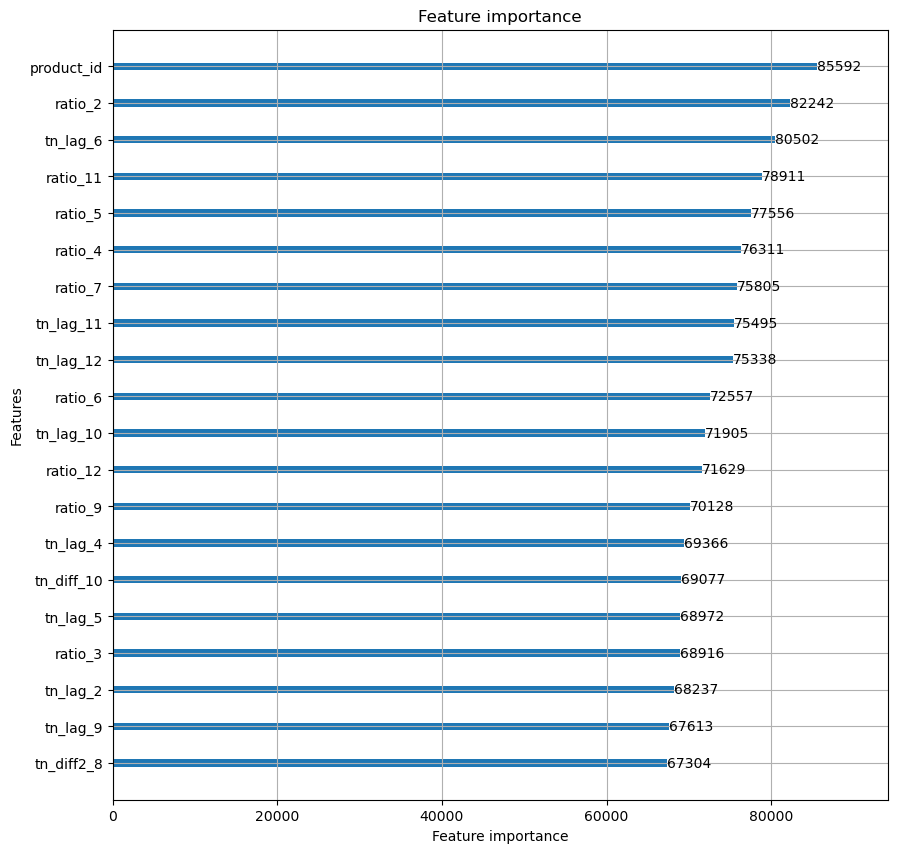

In [80]:
lgb.plot_importance(model, max_num_features=20, figsize=(10,10))
plt.show()

In [81]:
final = X_test
final['tn_futuro'] = y_test
final['tn_prediccion'] = y_pred

In [82]:
prod_stats = pd.read_parquet('prod_stats.parquet')
prod_stats = prod_stats[['product_id', 'average_tn','std_dev_tn']]
final = final.merge(prod_stats, how='left', on='product_id')
final.columns

Index(['product_id', 'periodo', 'primer_periodo', 'ultimo_periodo', 'tn_norm',
       'periodo_dt', 'mes', 'quarter', 'month_in_quarter', 'year',
       ...
       'crece_10', 'crece_11', 'crece_12', 'crece_13', 'crece_sum',
       'decrece_sum', 'tn_futuro', 'tn_prediccion', 'average_tn',
       'std_dev_tn'],
      dtype='object', length=114)

In [83]:
final['tn_futuro_real'] = (final['tn_norm'] + final['tn_futuro']) * final['std_dev_tn'] + final['average_tn']
final['tn_prediccion_real'] = (final['tn_norm'] + final['tn_prediccion']) * final['std_dev_tn'] + final['average_tn']

In [84]:
final.head()

,product_id,periodo,primer_periodo,ultimo_periodo,tn_norm,periodo_dt,mes,quarter,month_in_quarter,year,...,crece_12,crece_13,crece_sum,decrece_sum,tn_futuro,tn_prediccion,average_tn,std_dev_tn,tn_futuro_real,tn_prediccion_real
0,20001,201912,201701,201912,0.356686,201912,12,4,3,2019,...,False,False,5,7,NaN,-0.728222,1398.344322,298.145460,NaN,1287.572609
1,20002,201912,201701,201912,0.256522,201912,12,4,3,2019,...,True,False,6,6,NaN,-0.350038,1009.368178,303.834835,NaN,980.954824
2,20003,201912,201701,201912,0.011975,201912,12,4,3,2019,...,True,False,6,6,NaN,-0.607327,889.004243,292.036581,NaN,715.139474
3,20004,201912,201701,201912,-0.150213,201912,12,4,3,2019,...,False,False,5,7,NaN,-0.381328,671.615383,224.450085,NaN,552.310930
4,20005,201912,201701,201912,-0.233451,201912,12,4,3,2019,...,False,False,6,6,NaN,-0.248184,644.200514,218.273222,NaN,539.072602


In [85]:
final.to_parquet('sell_in_pred.parquet', index=False)